<a href="https://www.kaggle.com/code/hikmatullahmohammadi/simple-credit-fraud-detection-ps-s3e4?scriptVersionId=117261668" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id='0'></a>
# Playground Series - Season 3, Episode 4 (Credit Card Fraud Detection)

**Context:**<br>
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content:**<br>
The [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) contains transactions made by credit cards in September 2013 by European cardholders.<br>
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.<br><br>
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.<br><br>
Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Easy Navigation

- [1- Data Exploration](#1)
- [2- Explanatory Data Analysis (EDA)](#2)
- [3- Feature Engineering](#3)
- [4- Modeling](#4)
    - [4.1- Model Construction](#4-1)
    - [4.2- Model Utilization & Submission](#4-2)

In [1]:
# import required libraies/dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from warnings import simplefilter
simplefilter('ignore')

<a id='1'></a>
# 1- Data Exploration

In [2]:
# load datasets
df_train = pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv', index_col=0)
df_test = pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv', index_col=0)
df_orig = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [4]:
print(f'The training set contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.')

The training set contains 219129 rows and 31 columns.


We will combine the training set with the original dataset here. Because the target variable's distribution is biased, we only use those observations from the original dataset that have a Class value of 1

In [5]:
# combine the train set with the original dataset
df_orig_class_1 = df_orig[df_orig['Class']==1]
df_train = pd.concat([df_train, df_orig_class_1])
df_train.shape

(219621, 31)

In [6]:
# remove Time feature since it's insignificant
df_train.drop('Time', axis=1, inplace=True)
df_test.drop('Time', axis=1, inplace=True)
df_train.index = np.arange(df_train.shape[0])

---

<a id='2'></a>
# 2- Explanatory Data Analysis (EDA)

In [7]:
# extract categorical and numerical features
cate_features = ['Class']
numeric_features = list(set(df_train.columns)  - set(cate_features))

In [8]:
## utils/functions

# draw distribution plot for a numeric feature
def draw_numeric_dist(df, feature):
    sns.kdeplot(df[feature]) 
    ax = sns.distplot(df[feature])
    ax.set_title(f'{feature} Distribution', fontdict={'fontsize': 18})

# draw boxen plot for a numeric feature vs Attrition
def draw_numeric_target_boxen(df, feature):
    ax = sns.boxenplot(data=df, x='Class', y=feature)
    ax.set_title(f'{feature} VS Class', fontdict={'fontsize': 18})


<a id='2-1'></a>
## 2.1- Target Variable

Let's see the target's distribution

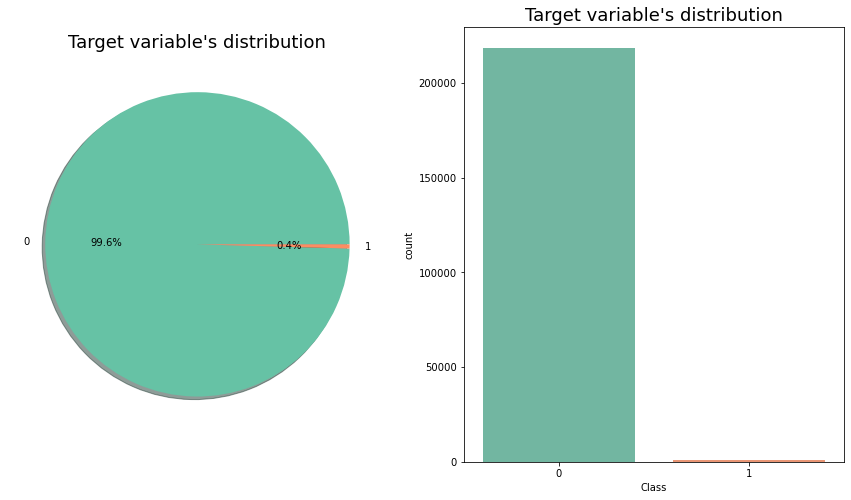

In [9]:
# draw the pie plots for all categorical features counts
plt.figure(figsize=(15, 8))
sns.set_palette('Set2')

plt.subplot(1, 2, 1)
plt.pie(
    x = df_train['Class'].value_counts(),
    labels=df_train['Class'].value_counts().index,
    autopct='%1.1f%%',
    shadow=True,
    startangle=0
)
plt.title(f'Target variable\'s distribution' , fontdict={'fontsize': 18})    

plt.subplot(1, 2, 2)
ax = sns.countplot(df_train['Class'])
ax.set_title(f'Target variable\'s distribution' , fontdict={'fontsize': 18})
plt.show()    

**It definitely shows bias. There is just 0.4% observations that have a Class value of 1**

---

<a id='2-2'></a>
## 2.2- Numeric features

**NOTE:**<br>
In this section we will visualize how each numeric feature is distributed, and how the distribution of each particular feature has an impact on the raget variable.

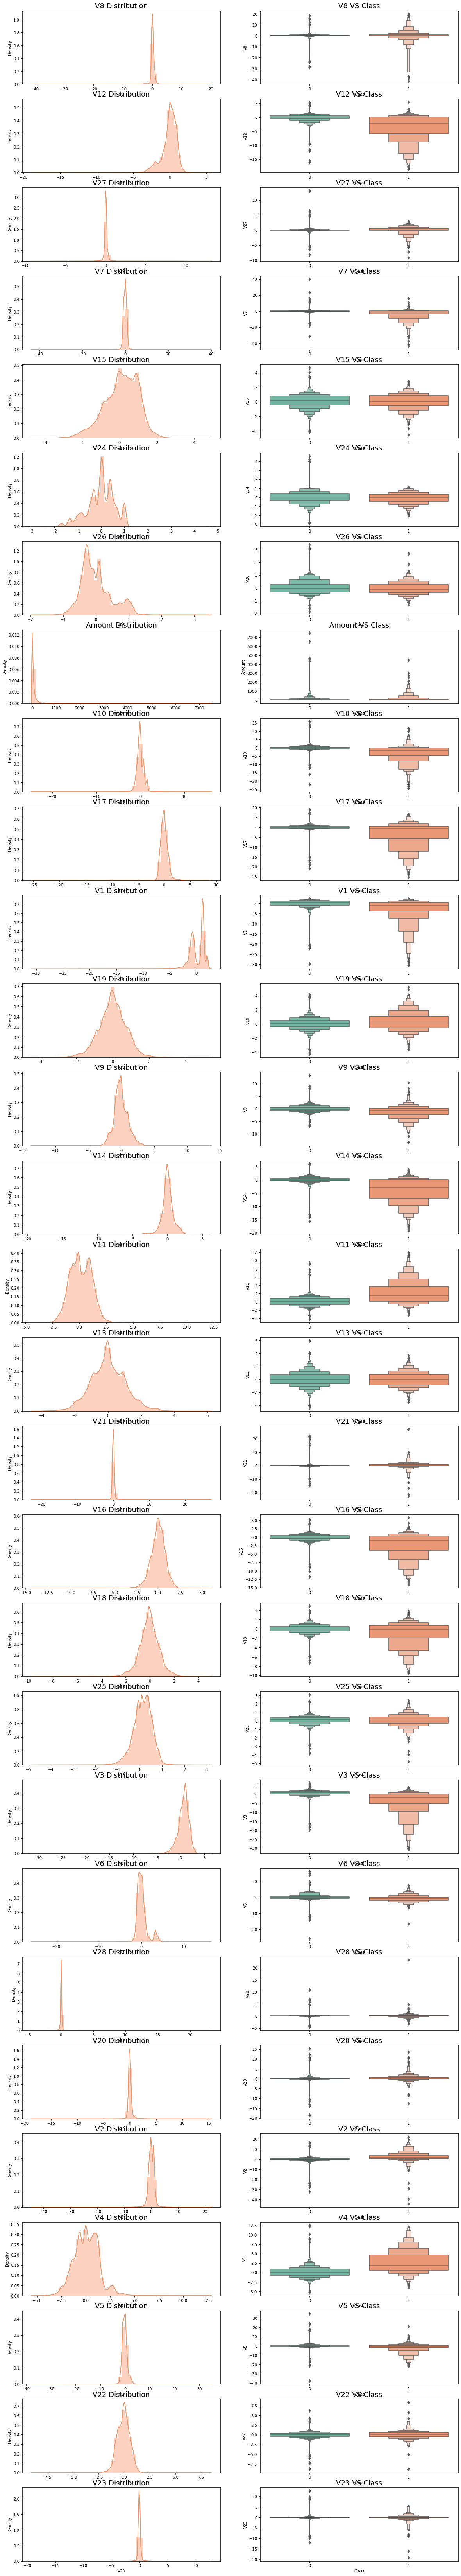

In [10]:
# draw some plots for all numeric features [+ vs Attrition]
plt.figure(figsize=(20, 120))
sns.set_palette('Set2')

i = 1
for feature in numeric_features:
    # dist
    plt.subplot(len(numeric_features), 2, i)
    draw_numeric_dist(df_train, feature)
    # box
    plt.subplot(len(numeric_features), 2, i+1)
    draw_numeric_target_boxen(df_train, feature)
    i += 2
    
plt.show()    

Above-displayed figures are quite self-explaining. Hence, I leave it to you to look at them and grasp how particular features are distributed, and how they have an impact on the target variable. **One thing which is very clear is that there are a lot of outliers (extreme values) which will be taken care of in later versions**

---

<a id='3'></a>
# 3- Feature Engineering

What is **Feature Engineering?**<br>
> Feature engineering is a machine learning technique that leverages data to create new variables that aren’t in the training set. It can produce new features for both supervised and unsupervised learning, with the goal of simplifying and speeding up data transformations while also enhancing model accuracy. (https://towardsdatascience.com/what-is-feature-engineering-importance-tools-and-techniques-for-machine-learning-2080b0269f10)

In [11]:
# TO DO in later versions:)

---

<a id='4'></a>
# 4- Modeling

<a id='4-1'></a>
## 4.1- Model Construction

In [12]:
# separatAgee the features from the target variable
X = df_train.drop('Class', axis=1)
y = df_train['Class'].astype('int')

In [13]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=10, shuffle=True)

In [14]:
# training
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier()
# fit it
ada_clf.fit(X_train, y_train)
print('Adaboost trained with an accuracy score of: ', ada_clf.score(X_val, y_val))

Adaboost trained with an accuracy score of:  0.9969494149251013


In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred_ada = ada_clf.predict(X_val)

print('Ada CM: ')
display(confusion_matrix(y_val, y_pred_ada))

Ada CM: 


array([[21858,     7],
       [   60,    38]])

<a id='4-2'></a>
## 4.2- Prediction & Submission

Because the objective in this competition is that we should predict the probability of an observation being Fraud, we will use `predict_proba()` method to accomplish so.

In [16]:
# predict on the test set
# classification
ada_preds = ada_clf.predict_proba(df_test)[:, 1]

In [17]:
# create a dataframe
submission = pd.DataFrame({
    'id': df_test.index,
    'Class': ada_preds
})
submission.head()

,id,Class
0,219129,0.474696
1,219130,0.461079
2,219131,0.462102
3,219132,0.468031
4,219133,0.466904


In [18]:
# write to a file
submission.to_csv('./submission.csv', index=False)
print('Done...')

Done...


# Thank you :)
By: [Hikmatullah Mohammadi](https://www.kaggle.com/hikmatullahmohammadi) <br>

[Go to top](#0)